In [1]:
import investpy
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp
plt.rcParams["figure.figsize"] = [10, 6]

investpy.etfs.get_etf_countries()
etf_list = investpy.etfs.get_etfs(country='united states')
print(etf_list)


            country                                            name  \
0     united states                AAM S&P 500 Sector High Dividend   
1     united states                 AAM S&P EM Sector High Dividend   
2     united states                              The Acquirers Fund   
3     united states                              Ranger Equity Bear   
4     united states               AdvisorShares Dorsey Wright Short   
...             ...                                             ...   
2159  united states  WisdomTree CBOE Russell 2000 PutWrite Strategy   
2160  united states                   WisdomTree Europe Multifactor   
2161  united states              Xtrackers Low Beta High Yield Bond   
2162  united states             Xtrackers High Beta High Yield Bond   
2163  united states             Xtrackers Short Duration High Yield   

                                           full_name symbol          isin  \
0                   AAM S&P 500 Sector High Dividend   SPDV  US26922A5

In [11]:
#gather up some data
shortnames = ["XLE","XLI","XLV","XLK","XLY","XLB","XLP"]
N_etf      = len(shortnames)

etf_data = []

for i in range(N_etf):
    
    fullname = etf_list.loc[etf_list['symbol'] == shortnames[i] ].name.to_string(index=False)
    
    etf_data.append(investpy.get_etf_historical_data(etf=fullname, 
                            country='united states', 
                            from_date='01/01/2015', 
                            to_date='01/01/2020',
                            interval='daily'))

    print(i, fullname)

0  Energy Select Sector SPDR
1  Industrial Select Sector SPDR
2  Health Care Select Sector SPDR
3  Technology Select Sector SPDR
4  Consumer Discretionary Select Sector SPDR
5  Materials Select Sector SPDR
6  Consumer Staples Select Sector SPDR


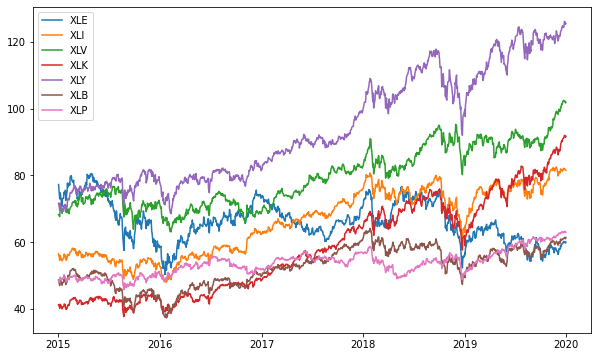

In [3]:
#plot the values over time

for i in range(N_etf):
    plt.plot(etf_data[i].Close,label=shortnames[i])
    
plt.legend()
plt.savefig('../figures/L10_portfolio_returns.pdf')

In [4]:
def compute_returns(s):
    
    r = [1] #take first element to be flat return to line up timestamps
    for j in range(1,len(s)):
        r.append(s[j]/s[j-1])
    return r
    

In [5]:

#compute the historical returns per ETF
for i in range(N_etf):
    etf_data[i]['Return'] = compute_returns(etf_data[i].Close)
      
        
#compute the means for each ETF
etf_means   = []
for i in range(N_etf):
    etf_means.append(np.sum(etf_data[i].Return)/len(etf_data[i]))

    
#compute historical deviations from the mean for each ETF
for i in range(N_etf):
    etf_data[i]['DeviationFromMean'] = etf_data[i]['Return'] - etf_means[i]


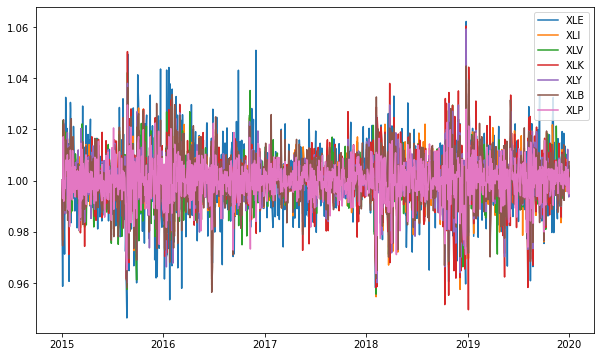

In [6]:
#plot the returns over time

for i in range(N_etf):
    plt.plot(etf_data[i].Return,label=shortnames[i])
    
plt.legend(loc='upper right')
plt.savefig('../figures/L10_portfolio_volatility.pdf')

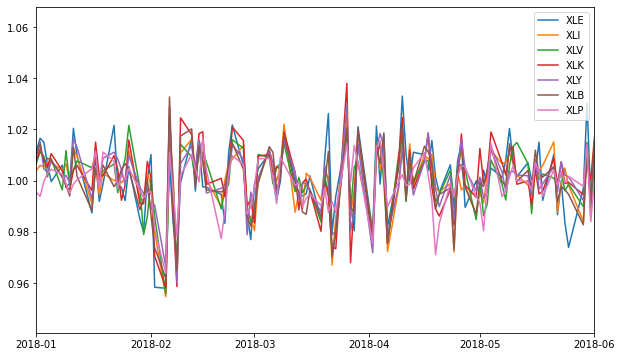

In [7]:
import datetime as dt
#plot the returns over a short window
left = dt.date(2018, 1, 1)
right = dt.date(2018, 6, 1)

for i in range(N_etf):
    plt.plot(etf_data[i].Return,label=shortnames[i])

plt.gca().set_xbound(left, right)
    
plt.legend(loc='upper right')
plt.savefig('../figures/L10_portfolio_volatility_window.pdf')

In [8]:
#make an optimal portfolio for some mu parameter
x    = cp.Variable(N_etf)
mu   = cp.Parameter(nonneg=True)
Tmax = len(etf_data[0])

reward = 0
risk   = 0

for i in range(N_etf):
    reward += etf_means[i]*x[i]


for T in range(Tmax):
    sum_xDFM = 0
    for j in range(N_etf):
        sum_xDFM += (x[j]*(etf_data[j]['DeviationFromMean'][T]))
    
    risk += cp.abs(sum_xDFM)
    
#normalize by timesteps
risk   = risk / Tmax
    
constraints = [x >= 0, cp.sum(x) == 1]
    
#form cvxpy problem
objective = reward - mu*risk
problem = cp.Problem(cp.Maximize(reward - mu * risk),constraints)

print(x.value)

None


In [9]:
#solve for different mu
muvals  = np.logspace(-2, 2, 50)

#make a dataframe to hold data from multiple solves
colnames = shortnames.copy()
colnames.extend(("risk","reward","mu"))
nrows   = len(muvals)
ncols   = len(colnames)
results = pd.DataFrame(np.zeros((nrows,ncols)),columns=colnames)


for i in tqdm(range(len(muvals))):
    mu.value = muvals[i]
    problem.solve()
    
    xval = x.value
    xval[xval <= 1e-10] = 0  #tidy up the solution
    
    for j in range(N_etf):
        results[shortnames[j]][i] = x.value[j]

    results['risk'][i] = risk.value
    results['reward'][i] = reward.value
    results['mu'][i] = mu.value
        
print(results)

100%|██████████| 50/50 [00:16<00:00,  3.01it/s]


         XLE       XLI       XLV       XLK       XLY  XLB       XLP      risk  \
0   0.000000  0.000000  0.000000  1.000000  0.000000  0.0  0.000000  0.007706   
1   0.000000  0.000000  0.000000  1.000000  0.000000  0.0  0.000000  0.007706   
2   0.000000  0.000000  0.000000  1.000000  0.000000  0.0  0.000000  0.007706   
3   0.000000  0.000000  0.000000  1.000000  0.000000  0.0  0.000000  0.007706   
4   0.000000  0.000000  0.000000  1.000000  0.000000  0.0  0.000000  0.007706   
5   0.000000  0.000000  0.000000  1.000000  0.000000  0.0  0.000000  0.007706   
6   0.000000  0.000000  0.000000  1.000000  0.000000  0.0  0.000000  0.007706   
7   0.000000  0.000000  0.000000  1.000000  0.000000  0.0  0.000000  0.007706   
8   0.000000  0.000000  0.000000  1.000000  0.000000  0.0  0.000000  0.007706   
9   0.000000  0.000000  0.000000  1.000000  0.000000  0.0  0.000000  0.007706   
10  0.000000  0.000000  0.000000  1.000000  0.000000  0.0  0.000000  0.007706   
11  0.000000  0.000000  0.00

Text(0.5, 1.0, 'Pareto frontier')

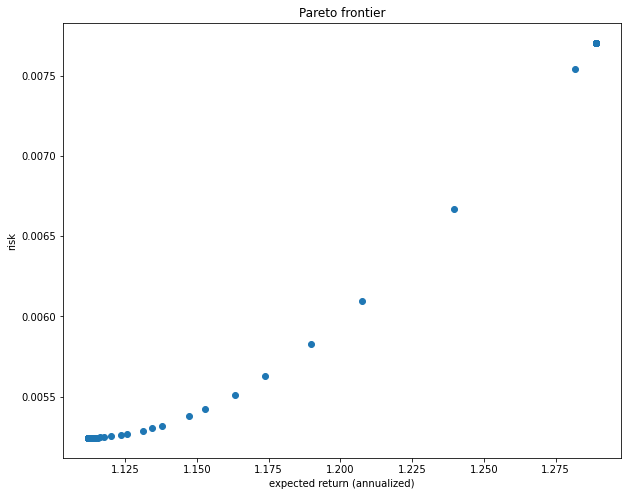

In [10]:
#plot the pareto frontier
plt.rcParams["figure.figsize"] = [10, 8]
plt.scatter(np.power(results['reward'],365),results['risk'])
plt.xlabel('expected return (annualized)')
plt.ylabel('risk')
plt.title('Pareto frontier')